<a href="https://colab.research.google.com/github/Orange314159/DataScience/blob/main/MattRobsU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install -q "preliz[full,notebook]"
!pip install -q bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.1 MB/s eta 0:00:00


In [3]:
import bambi as bmb
import preliz as pz

# The Stock Price of Nvidia

## Background

The first and most important part of any project like this is to consider the connections between variables and priors that may influence the variable that I want to study. In order to do this I will create a graph.

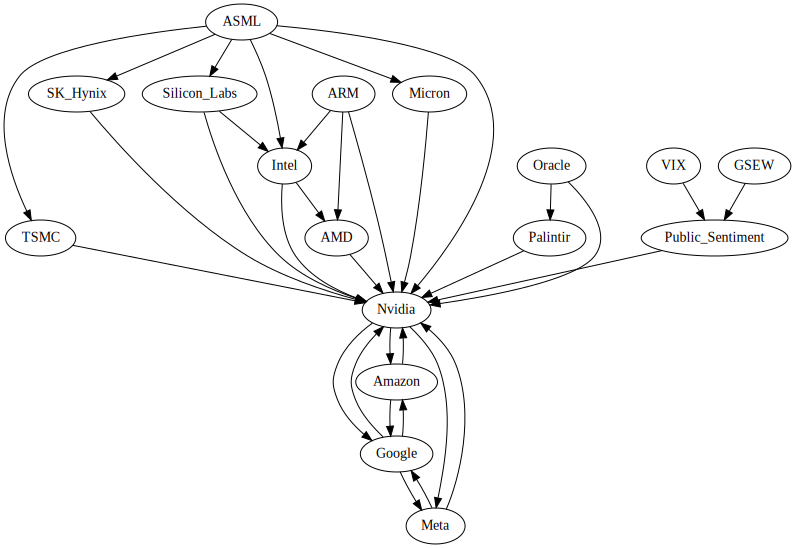

In [61]:
b_dag = gv.Digraph(name="Nvidia Stock DAG")

b_dag.node('N','Nvidia')
b_dag.node('T','TSMC')
b_dag.node('A','ASML')
b_dag.node('S','SK_Hynix')
b_dag.node('I','Intel')
b_dag.node('D','AMD')
b_dag.node('Z','Amazon')
b_dag.node('G','Google')
b_dag.node('M','Meta')
b_dag.node('R','ARM')
b_dag.node('L','Silicon_Labs')
b_dag.node('W','GSEW')
b_dag.node('P','Palintir')
b_dag.node('V','VIX')
b_dag.node('O','Oracle')
b_dag.node('E','Public_Sentiment')
b_dag.node('C', 'Micron')


b_dag.edges(['TN', 'SN', 'AT', 'AS', 'AN', 'GN', 'ZN', 'MN', 'IN', 'DN', 'WE', 'VE', 'EN', 'PN', 'ID', 'GZ', 'ON', 'RN', 'NG', 'NZ', 'MG', 'ZG', 'GM', 'NM', 'RI', 'RD', 'AI', 'AL', 'LN', 'LI', 'OP', 'AC', 'CN'])

b_dag

## Data Collection

Well that is deffinately something. There are a lot of connections here and I wish to do this graph justice, but likely it will have to be pared down in some way to be able to predict it properly.

Now to justify why I made all of these connections, and what other connections I might be missing. First we have to consider the different "sections" that I have used to judge the Nvidia stock price. First is the foundry and labs. This includes Sk_Hynix, TSMC, Silicon Labs, ASML, and Intel in some ways. These are companies that build computer chips or build the tools to build chips. The idea behind these influencing Nvidia stock price is that they produce the chips that Nvidia uses or competes for so they could influence how well Nvidia is doing. The next section is the major server farms that employ all of the Nvidia chips. This includes companies like Amazon, Google, and Meta. All three of these companies have major server farms that use Nvidia chips and so if these companies are doing well and are buying more chips, it stands to reason that Nvidia may also be doing well. Next are the competitors with Nvidia. This includes Intel and AMD. Both of these companies also build GPUs which are in direct competition with Nvidia. ARM is also in a similar-ish position where it influences both Intel and AMD's chip development along with also influencing Nvidia. Next are the companies that are AI focused and therefore rely heavily on the development of AI chips made by Nvidia. This includes Oracle and Palintir. While I did wish to include more companies like OpenAI, Anthropic, Preplexity and many more, these companies are all privately held and hard to track their progress. Finally, I thought it would be good to include a public sentiment because Nvidia, like all other stock prices, will fluctuate with the rest of the stock market. In order to improve this from last time I am using an equally weighted index in order to avoid conflicts from over reliance on Nvidia. The S&P for example is about 8% Nvidia alone, so using it to predict Nvidia is kinda cheating.

In order to get the data I will access the file in my google drive.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


I can now create a data frame using this data.

In [6]:
stockData = pd.read_csv("/content/drive/MyDrive/DataScience/Project7DataSet.csv")
print(stockData.columns)

Index(['Micron', 'Meta', 'ARM', 'Palintir', 'SiliconLabs', 'Oracle', 'Google',
       'Nvidia', 'Amazon', 'ASML', 'SKHynix', 'TSMC', 'AMD', 'Intel', 'GESW',
       'VIX'],
      dtype='object')


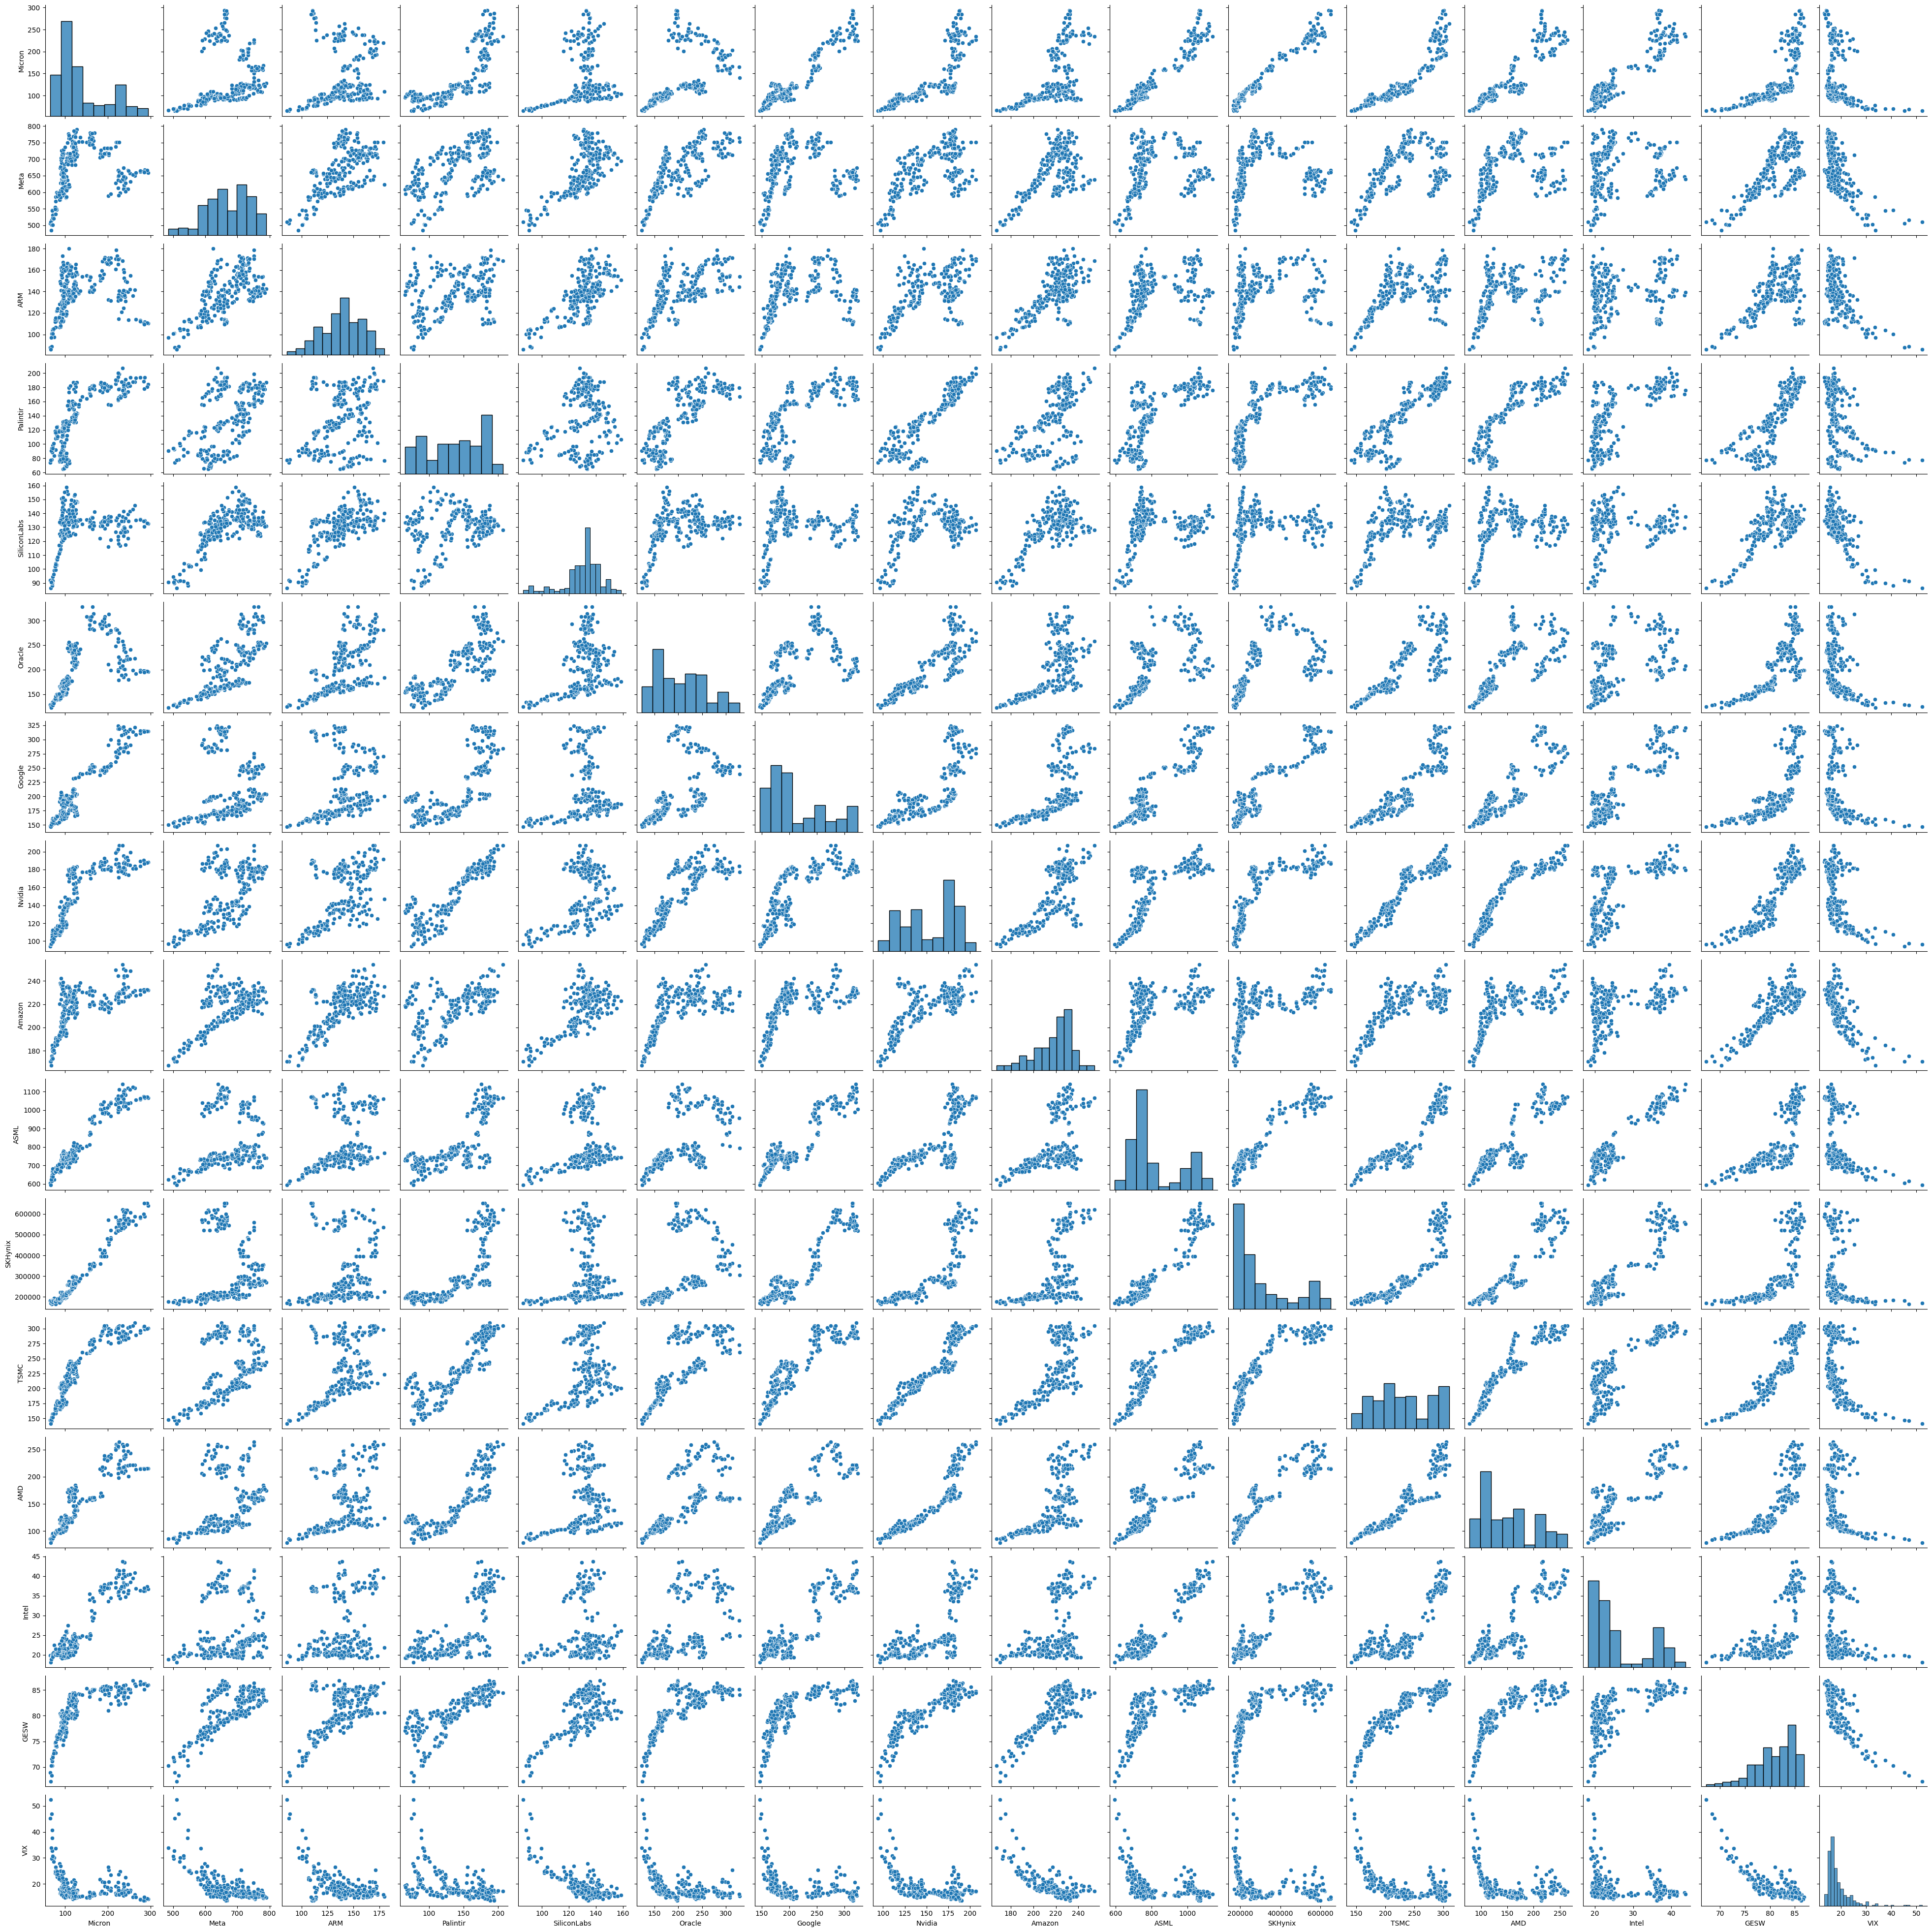

In [7]:
sns.pairplot(stockData)
plt.show()

From here I will start to analyze the data set with different types of models. My first step will be to consider how the priors relate to the stock price of Nvidia. A linear model looks like a good place to start, but I think there will be some issues that I will run into.

## Google

In [ ]:
model_poly_1 = bmb.Model("Nvidia ~ Google", stockData, family="negativebinomial")
idata_poly_1 = model_poly_1.fit()

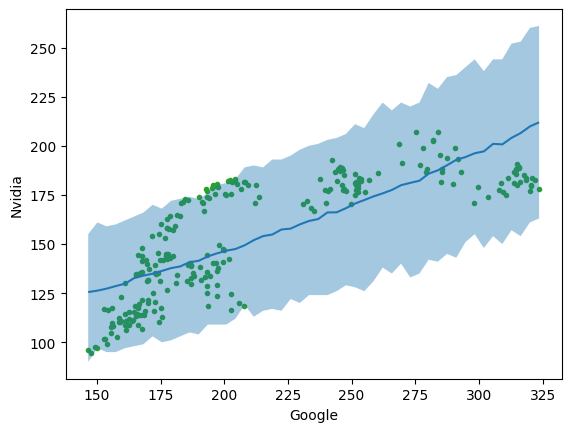

In [9]:
bmb.interpret.plot_predictions(model_poly_1, idata_poly_1, "Google", pps=True)
plt.plot(stockData.Google, stockData.Nvidia, "C2.", zorder=-3);

And this is what I had expected, it looks "ok", but there clearly could be some improvement. Lets try using a higher degreee polynomial, maybe 4?

In [ ]:
model_poly_4 = bmb.Model("Nvidia ~ poly(Google, degree=4)", stockData, family="negativebinomial")
idata_poly_4 = model_poly_4.fit()

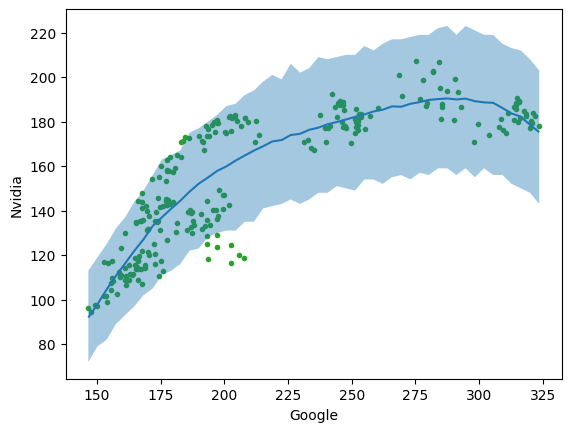

In [11]:
bmb.interpret.plot_predictions(model_poly_4, idata_poly_4, "Google", pps=True)
plt.plot(stockData.Google, stockData.Nvidia, "C2.", zorder=-3);

Now this deffinately looks better, but lets try a few other options first. I am a little concerned by the downward slope at the end (I would expect more of a flat slope).

The next thing that I will try is adding splines into the model.

In [ ]:
num_knots = 5
knots = np.linspace(stockData.Google.min(), stockData.Google.max(), num_knots+2)[1:-1]
model_spline = bmb.Model("Nvidia ~ bs(Google, degree=1, knots=knots)", stockData, family="negativebinomial")
idata_spline = model_spline.fit()

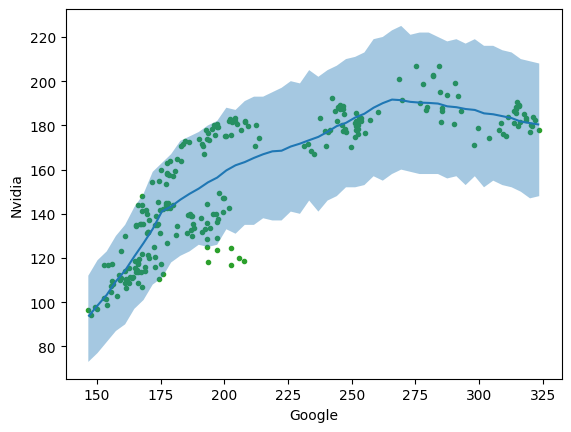

In [13]:
bmb.interpret.plot_predictions(model_spline, idata_spline, "Google", pps= True)
plt.plot(stockData.Google, stockData.Nvidia, "C2.", zorder=-3);

Now this also look pretty good. I am thinking that I might be able to improve it though.

In [ ]:
num_knots = 5
knots = np.linspace(stockData.Google.min(), stockData.Google.max(), num_knots+2)[1:-1]
model_spline = bmb.Model("Nvidia ~ bs(Google, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline = model_spline.fit()

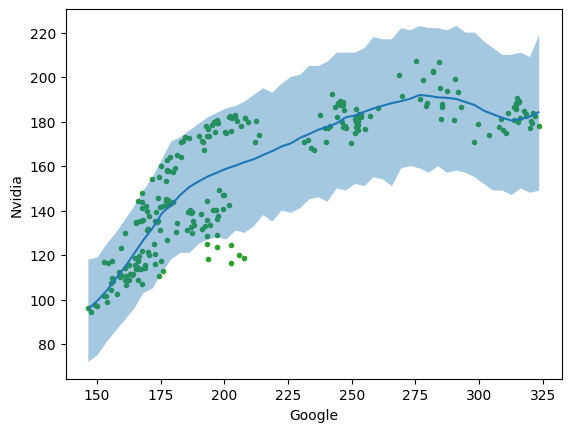

In [15]:
bmb.interpret.plot_predictions(model_spline, idata_spline, "Google", pps= True)
plt.plot(stockData.Google, stockData.Nvidia, "C2.", zorder=-3);

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


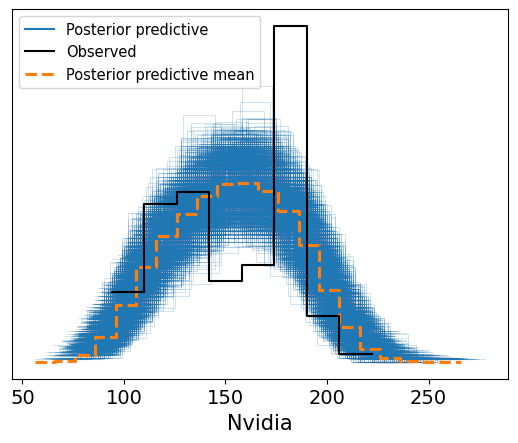

In [16]:
model_spline.predict(idata_spline, kind="response")
az.plot_ppc(idata_spline);

Ok, based on how all of these look I think I will use the final option. It does look a little bit like it is overfitting, but I think it actually is just picking up on smaller trends in the data that I find important (it will be seen if this ages well or if I made a bad judgment here).

One final thing that I will do before speeding up the pace and adding a bunch more priors is test out how well a HSGP works on the data set.

In [17]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
  """Credit to  Mr. Arredondo for writing this funciton in its entirety."""
  differences = np.abs(np.subtract.outer(x_vals, x_vals))
  if l_b is None:
      l_b = np.min(differences[differences != 0]) * 2
  if u_b is None:
      u_b = np.max(differences) / 1.5

  dist = pz.InverseGamma()
  pz.maxent(dist, l_b, u_b, mass, plot=plot)

  return dict(zip(dist.param_names, dist.params))

In [18]:
Nvidia = stockData["Nvidia"].values
Google = stockData["Google"].values[:,None]

In [ ]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(Google))
}

priors = {
    "hsgp(Google, m=10, c=10.0)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("Nvidia ~ 0 + hsgp(Google, m=10, c=10.0)", stockData, family="negativebinomial", priors=priors)
idata_hsb = model_hsb.fit()

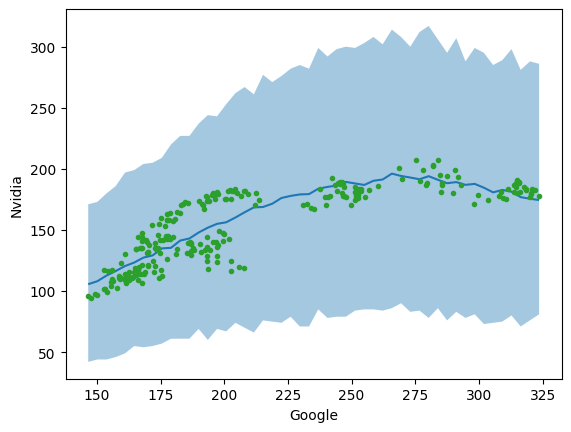

In [20]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["Google"], pps = True)
ax[0].plot(stockData["Google"].values, stockData["Nvidia"].values, "C2.");

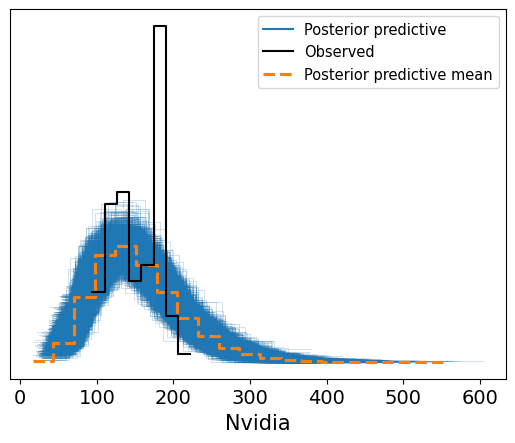

In [21]:
model_hsb.predict(idata_hsb, kind="response")

az.plot_ppc(idata_hsb);

This is ok, but I still prefer 5 knot, 3 degree polynomial fit.

Now, let's start on the rest of the priors.

## Amazon

In [ ]:
num_knots = 5
knots = np.linspace(stockData.Amazon.min(), stockData.Amazon.max(), num_knots+2)[1:-1]
model_spline_amazon = bmb.Model("Nvidia ~ bs(Amazon, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_amazon = model_spline_amazon.fit()

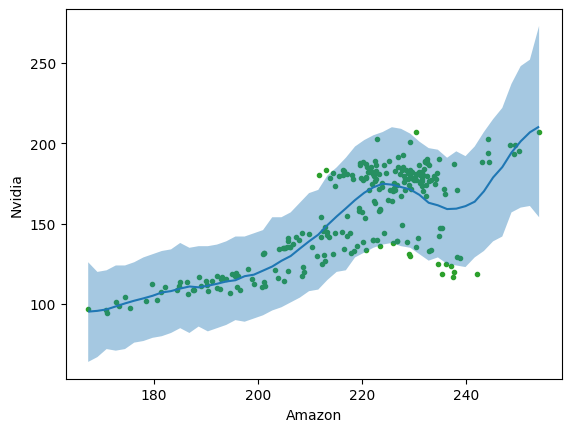

In [23]:
bmb.interpret.plot_predictions(model_spline_amazon, idata_spline_amazon, "Amazon", pps= True)
plt.plot(stockData.Amazon, stockData.Nvidia, "C2.", zorder=-3);

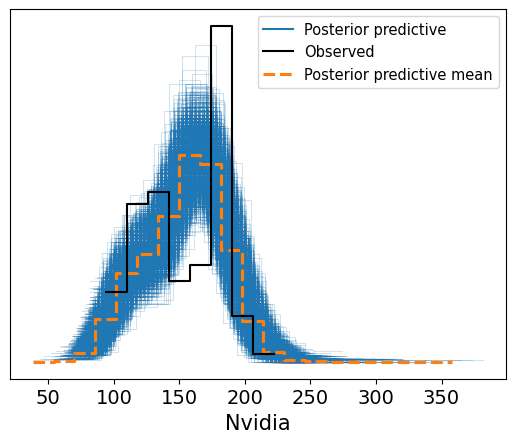

In [24]:
model_spline_amazon.predict(idata_spline_amazon, kind="response")
az.plot_ppc(idata_spline_amazon);

## Oracle

In [ ]:
num_knots = 5
knots = np.linspace(stockData.Oracle.min(), stockData.Oracle.max(), num_knots+2)[1:-1]
model_spline_oracle = bmb.Model("Nvidia ~ bs(Oracle, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_oracle = model_spline_oracle.fit()

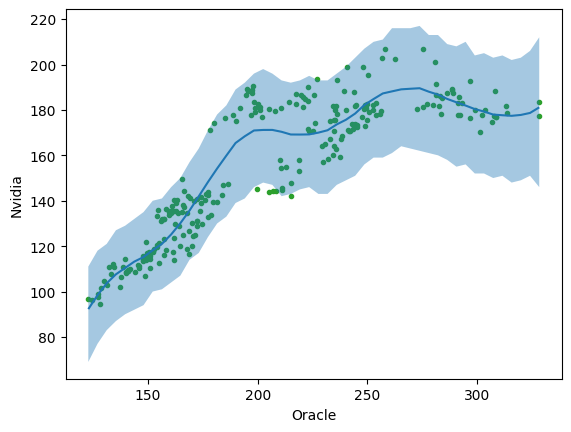

In [26]:
bmb.interpret.plot_predictions(model_spline_oracle, idata_spline_oracle, "Oracle", pps= True)
plt.plot(stockData.Oracle, stockData.Nvidia, "C2.", zorder=-3);

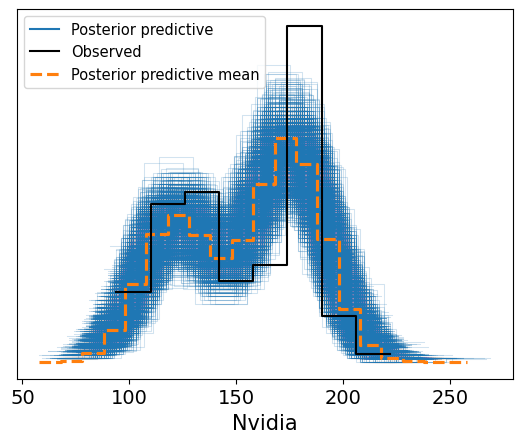

In [27]:
model_spline_oracle.predict(idata_spline_oracle, kind="response")
az.plot_ppc(idata_spline_oracle);

## TSMC

In [ ]:
num_knots = 5
knots = np.linspace(stockData.TSMC.min(), stockData.TSMC.max(), num_knots+2)[1:-1]
model_spline_TSMC = bmb.Model("Nvidia ~ bs(TSMC, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_TSMC = model_spline_TSMC.fit()

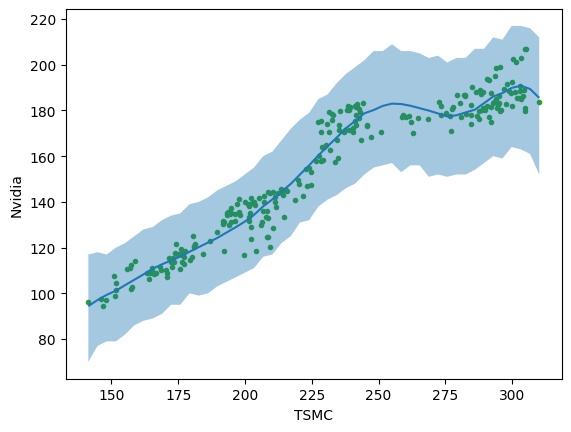

In [29]:
bmb.interpret.plot_predictions(model_spline_TSMC, idata_spline_TSMC, "TSMC", pps= True)
plt.plot(stockData.TSMC, stockData.Nvidia, "C2.", zorder=-3);

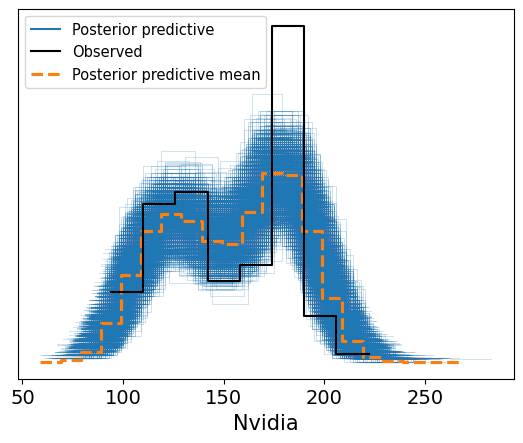

In [30]:
model_spline_TSMC.predict(idata_spline_TSMC, kind="response")
az.plot_ppc(idata_spline_TSMC);

## SK Hynix

In [ ]:
num_knots = 5
knots = np.linspace(stockData.SKHynix.min(), stockData.SKHynix.max(), num_knots+2)[1:-1]
model_spline_SKHynix = bmb.Model("Nvidia ~ bs(SKHynix, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_SKHynix = model_spline_SKHynix.fit()

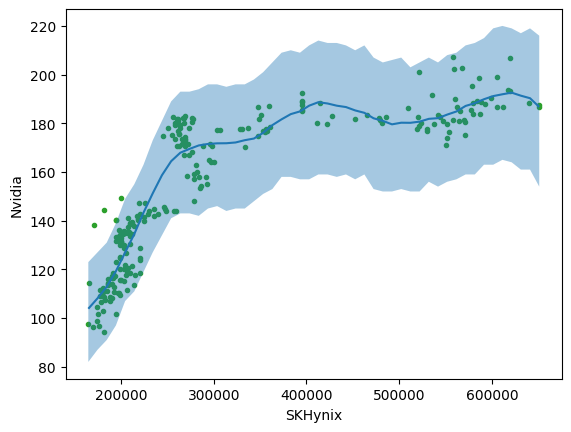

In [32]:
bmb.interpret.plot_predictions(model_spline_SKHynix, idata_spline_SKHynix, "SKHynix", pps= True)
plt.plot(stockData.SKHynix, stockData.Nvidia, "C2.", zorder=-3);

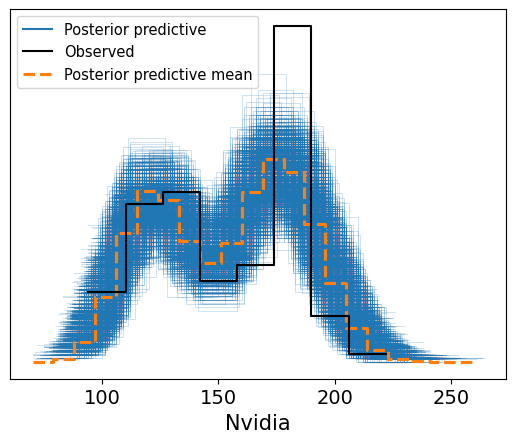

In [33]:
model_spline_SKHynix.predict(idata_spline_SKHynix, kind="response")
az.plot_ppc(idata_spline_SKHynix);

## ASML

In [ ]:
num_knots = 5
knots = np.linspace(stockData.ASML.min(), stockData.ASML.max(), num_knots+2)[1:-1]
model_spline_ASML = bmb.Model("Nvidia ~ bs(ASML, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_ASML = model_spline_ASML.fit()

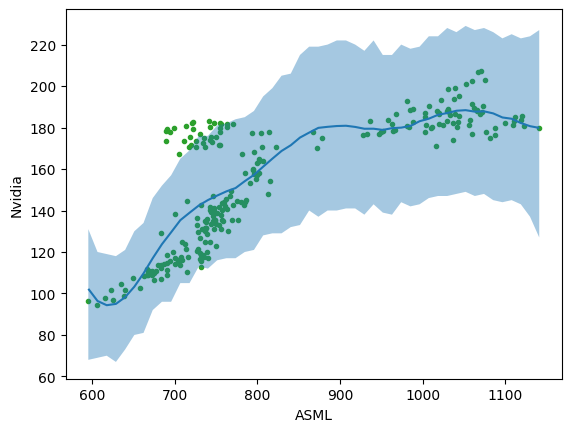

In [35]:
bmb.interpret.plot_predictions(model_spline_ASML, idata_spline_ASML, "ASML", pps= True)
plt.plot(stockData.ASML, stockData.Nvidia, "C2.", zorder=-3);

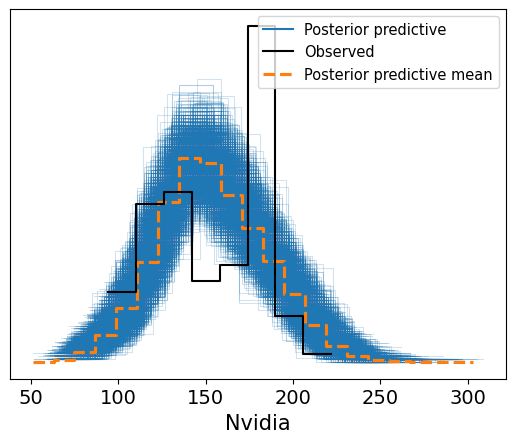

In [36]:
model_spline_ASML.predict(idata_spline_ASML, kind="response")
az.plot_ppc(idata_spline_ASML);

## Intel

In [ ]:
num_knots = 5
knots = np.linspace(stockData.Intel.min(), stockData.Intel.max(), num_knots+2)[1:-1]
model_spline_Intel = bmb.Model("Nvidia ~ bs(Intel, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_Intel = model_spline_Intel.fit()

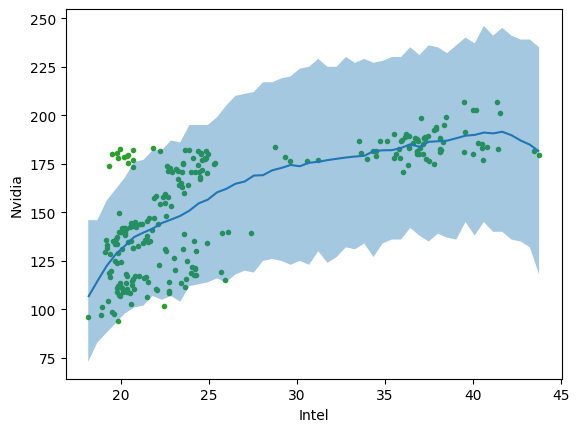

In [38]:
bmb.interpret.plot_predictions(model_spline_Intel, idata_spline_Intel, "Intel", pps= True)
plt.plot(stockData.Intel, stockData.Nvidia, "C2.", zorder=-3);

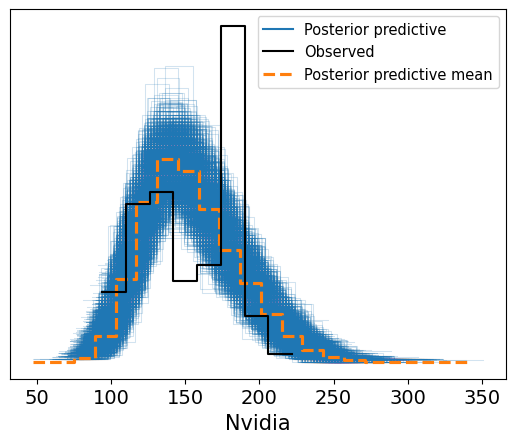

In [39]:
model_spline_Intel.predict(idata_spline_Intel, kind="response")
az.plot_ppc(idata_spline_Intel);

## AMD

In [ ]:
num_knots = 5
knots = np.linspace(stockData.AMD.min(), stockData.AMD.max(), num_knots+2)[1:-1]
model_spline_AMD = bmb.Model("Nvidia ~ bs(AMD, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_AMD = model_spline_AMD.fit()

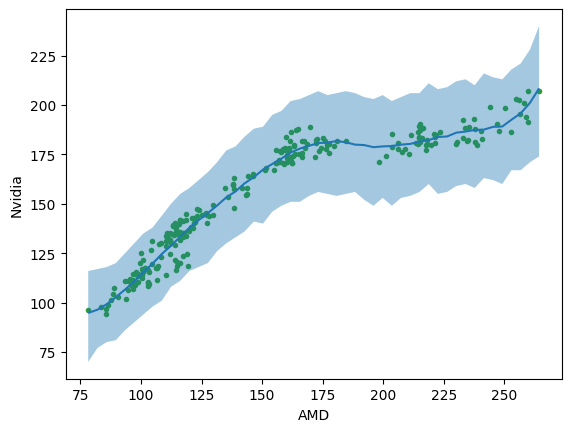

In [41]:
bmb.interpret.plot_predictions(model_spline_AMD, idata_spline_AMD, "AMD", pps= True)
plt.plot(stockData.AMD, stockData.Nvidia, "C2.", zorder=-3);

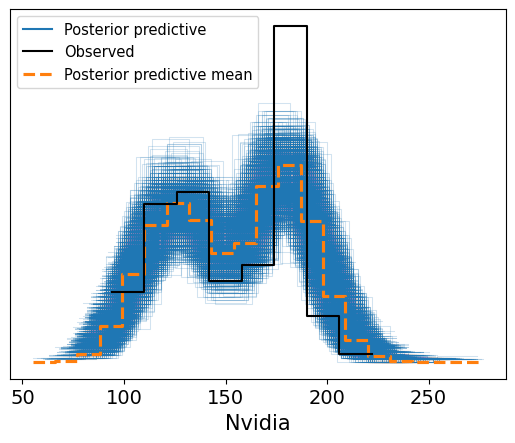

In [42]:
model_spline_AMD.predict(idata_spline_AMD, kind="response")
az.plot_ppc(idata_spline_AMD);

## Meta

In [ ]:
num_knots = 5
knots = np.linspace(stockData.Meta.min(), stockData.Meta.max(), num_knots+2)[1:-1]
model_spline_Meta = bmb.Model("Nvidia ~ bs(Meta, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_Meta = model_spline_Meta.fit()

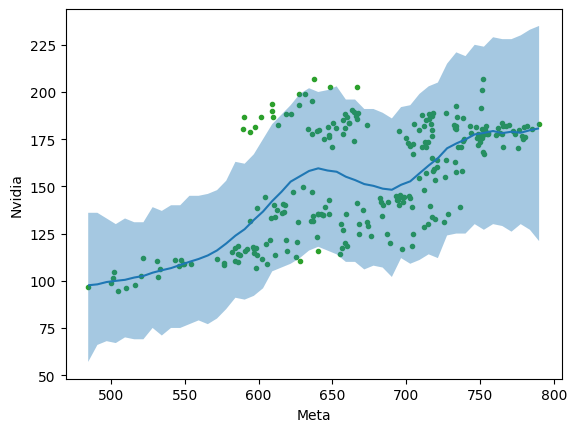

In [44]:
bmb.interpret.plot_predictions(model_spline_Meta, idata_spline_Meta, "Meta", pps= True)
plt.plot(stockData.Meta, stockData.Nvidia, "C2.", zorder=-3);

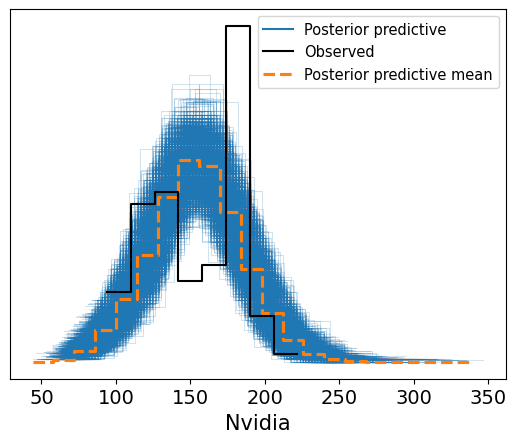

In [45]:
model_spline_Meta.predict(idata_spline_Meta, kind="response")
az.plot_ppc(idata_spline_Meta);

## ARM

In [ ]:
num_knots = 5
knots = np.linspace(stockData.ARM.min(), stockData.ARM.max(), num_knots+2)[1:-1]
model_spline_ARM = bmb.Model("Nvidia ~ bs(ARM, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_ARM = model_spline_ARM.fit()

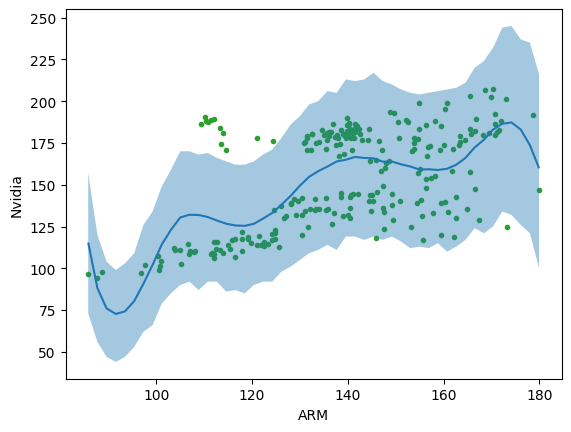

In [47]:
bmb.interpret.plot_predictions(model_spline_ARM, idata_spline_ARM, "ARM", pps= True)
plt.plot(stockData.ARM, stockData.Nvidia, "C2.", zorder=-3);

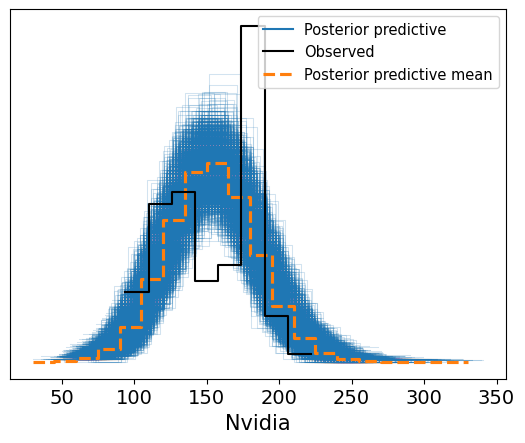

In [48]:
model_spline_ARM.predict(idata_spline_ARM, kind="response")
az.plot_ppc(idata_spline_ARM);

## Silicon Labs

In [ ]:
num_knots = 5
knots = np.linspace(stockData.SiliconLabs.min(), stockData.SiliconLabs.max(), num_knots+2)[1:-1]
model_spline_SiliconLabs = bmb.Model("Nvidia ~ bs(SiliconLabs, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_SiliconLabs = model_spline_SiliconLabs.fit()

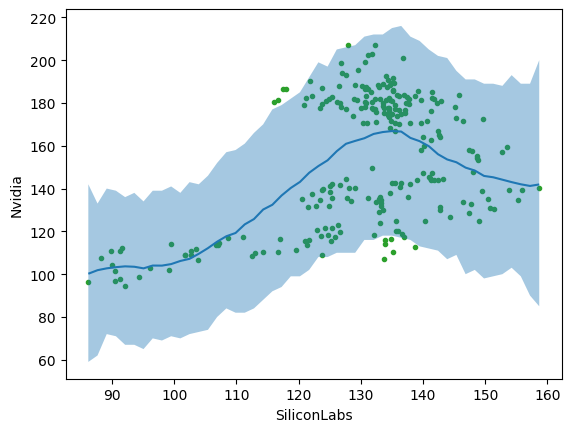

In [50]:
bmb.interpret.plot_predictions(model_spline_SiliconLabs, idata_spline_SiliconLabs, "SiliconLabs", pps= True)
plt.plot(stockData.SiliconLabs, stockData.Nvidia, "C2.", zorder=-3);

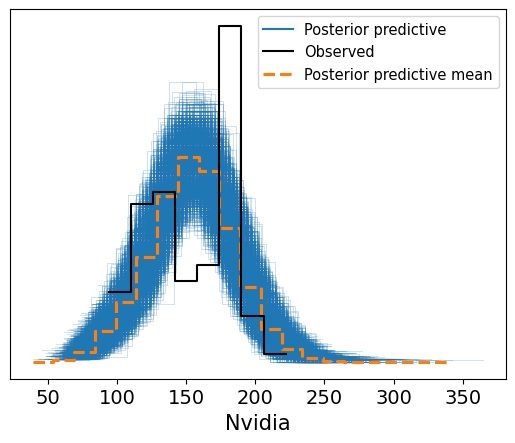

In [51]:
model_spline_SiliconLabs.predict(idata_spline_SiliconLabs, kind="response")
az.plot_ppc(idata_spline_SiliconLabs);

## GSEW

In [ ]:
num_knots = 5
knots = np.linspace(stockData.GESW.min(), stockData.GESW.max(), num_knots+2)[1:-1]
model_spline_GESW = bmb.Model("Nvidia ~ bs(GESW, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_GESW = model_spline_GESW.fit()

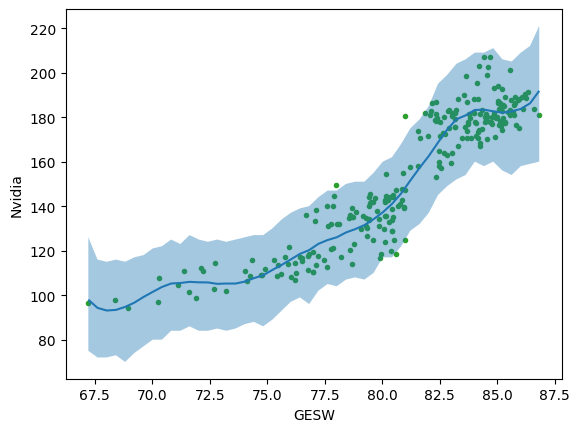

In [53]:
bmb.interpret.plot_predictions(model_spline_GESW, idata_spline_GESW, "GESW", pps= True)
plt.plot(stockData.GESW, stockData.Nvidia, "C2.", zorder=-3);

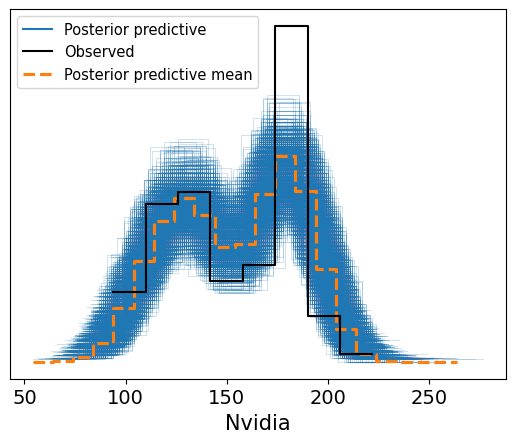

In [54]:
model_spline_GESW.predict(idata_spline_GESW, kind="response")
az.plot_ppc(idata_spline_GESW);

## Palintir

In [ ]:
num_knots = 5
knots = np.linspace(stockData.Palintir.min(), stockData.Palintir.max(), num_knots+2)[1:-1]
model_spline_Palintir = bmb.Model("Nvidia ~ bs(Palintir, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_Palintir = model_spline_Palintir.fit()

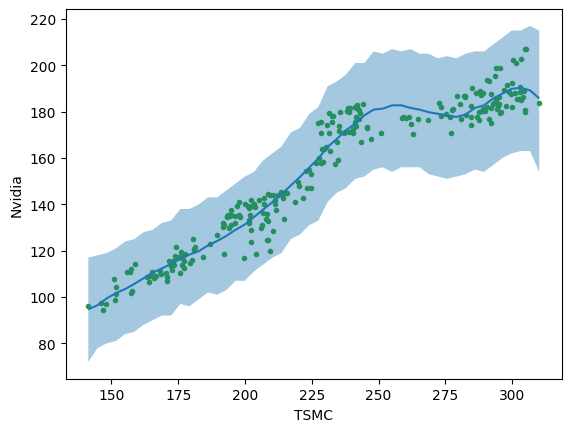

In [56]:
bmb.interpret.plot_predictions(model_spline_Palintir, idata_spline_Palintir, "Palintir", pps= True)
plt.plot(stockData.Palintir, stockData.Nvidia, "C2.", zorder=-3);

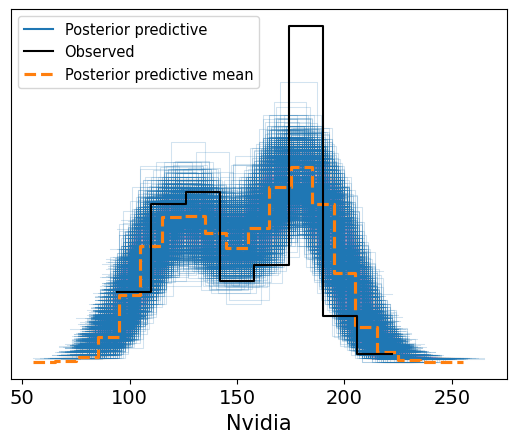

In [57]:
model_spline_Palintir.predict(idata_spline_Palintir, kind="response")
az.plot_ppc(idata_spline_Palintir);

## VIX

In [ ]:
num_knots = 5
knots = np.linspace(stockData.VIX.min(), stockData.VIX.max(), num_knots+2)[1:-1]
model_spline_VIX = bmb.Model("Nvidia ~ bs(VIX, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_VIX = model_spline_VIX.fit()

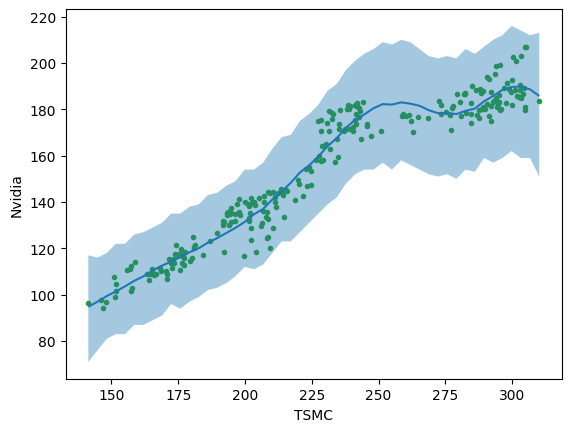

In [59]:
bmb.interpret.plot_predictions(model_spline_VIX, idata_spline_VIX, "VIX", pps= True)
plt.plot(stockData.VIX, stockData.Nvidia, "C2.", zorder=-3);

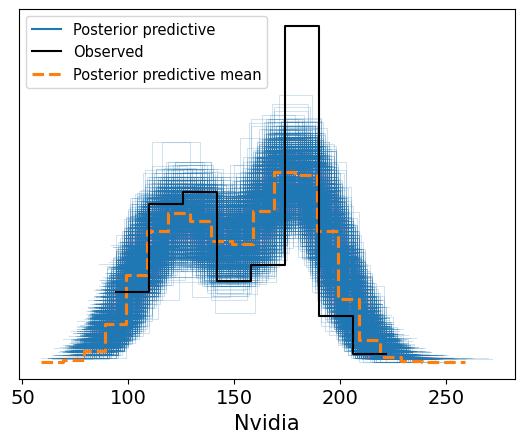

In [60]:
model_spline_VIX.predict(idata_spline_VIX, kind="response")
az.plot_ppc(idata_spline_VIX);

## Micron

In [ ]:
num_knots = 5
knots = np.linspace(stockData.Micron.min(), stockData.Micron.max(), num_knots+2)[1:-1]
model_spline_Micron = bmb.Model("Nvidia ~ bs(Micron, degree=3, knots=knots)", stockData, family="negativebinomial")
idata_spline_Micron = model_spline_Micron.fit()

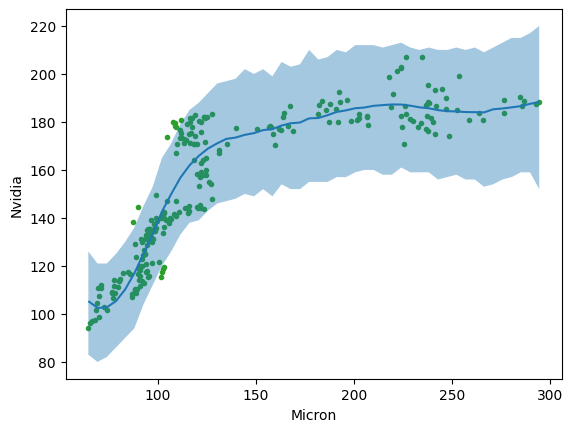

In [63]:
bmb.interpret.plot_predictions(model_spline_Micron, idata_spline_Micron, "Micron", pps= True)
plt.plot(stockData.Micron, stockData.Nvidia, "C2.", zorder=-3);

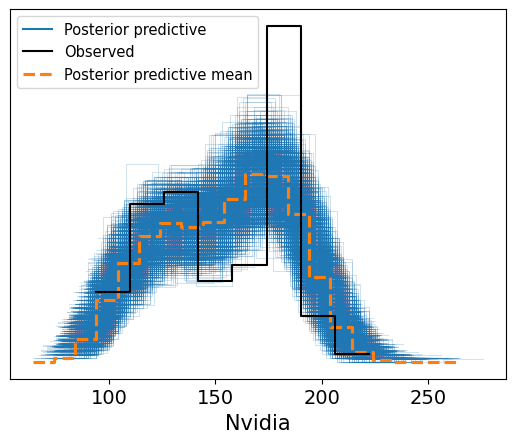

In [64]:
model_spline_Micron.predict(idata_spline_Micron, kind="response")
az.plot_ppc(idata_spline_Micron);